## Inferência de parâmetros cosmológicos com emcee e polychord usando dados de Cronômetros Cósmicos e Supernovas.

Este caderno foi escrito por Jéferson Fortunato - apenas para propósitos didáticos. 

<p style="text-align:justify">Para que um problema de inferência estatística seja totalmente especificado, é necessário definir um modelo – no qual os parâmetros podem variar de acordo com suas distribuições de probabilidades a priori – e a função de verossimilhança para os dados considerados. Sendo assim, neste notebook reproduz-se um exemplo bastante comum em cosmologia, que consiste em estimar os valores atuais do parâmetro de Hubble $H_0$ e da densidade de matéria do Universo $\Omega_m$, assumindo o modelo padrão $\Lambda CDM$. </p>

<p style="text-align:justify"> A implementação desse exemplo foi realizada diante um conjunto de $41$ medidas observacionais do parâmetro de Hubble em termos de redshift, $H(z)$, a partir da abordagem conhecida como Cronômetros Cósmicos. Esse método utiliza galáxias vermelhas, que são objetos super massivos e possuem as populações de estrelas mais anciãs, como também possuem pouca poeira estelar, o que favorece a obtenção do seu espectro luminoso e permite medir $H(z)$ diretamente. Também foi usado o conjunto de dados do Pantheon, que consiste na maior coleção de Supernovas do tipo Ia já realizada, contendo $1048$ medidas cobrindo a faixa de redshift $0 < z < 2.3$.</p>

#### $\Lambda CDM$ plano

<p style="text-align:justify"> O modelo $\Lambda CDM$ plano é representado pela seguinte equação: </p>

$$ H^2(z) = H_0^2 [\Omega_{m0} (1+z)^3 + \Omega_{\Lambda 0}],$$

<p style="text-align:justify"> sendo $\Omega_{m0} + \Omega_{\Lambda 0} = 1$. </p>

<p style="text-align:justify"> Nesse modelo a distância de luminosidade é dada por:</p>

$$D_L = \frac{c}{H_0}\int_0^z \frac{dz'}{E(z')},$$

<p style="text-align:justify"> com $E(z)=H(z)/H_0$.</p>

<p style="text-align:justify"> Para as Supernovas do tipo Ia, usaremos as equações que relacionam o módulo de distância e a distância de luminosidade:</p>

$$ \mu=mB-\mathcal{M}, $$

$$\mu=5log_{10} D_L+25.$$

### Metodologia

<p style="text-align:justify"> Para os Cronômetros Cósmicos, usa-se a seguinte estatística de $\chi^2$ :</p>

$$\chi_{H}^2=\sum_i\left[\frac{H(z_i,H_0, \theta)-H_{obs,i}}{\sigma_{H,i}}\right]^2.$$

<p style="text-align:justify"> No caso das Supernovas, usaremos a forma do $\chi^2$ para a magnitude aparente $m_B$ com $\mathcal{M}$ marginalizado, usando as relações seguintes: </p>

$$A = \sum_{i=1} \frac{(m_B(z_i, \theta) - {m_B}_{obs,i})^2}{\sigma_i^2},$$
$$B = \sum_{i=1} \frac{(m_B(z_i, \theta) - {m_B}_{obs,i})}{\sigma_i^2},$$
$$C = \sum_{i=1} \frac{1}{\sigma_i^2},$$

<p style="text-align:justify"> de maneira que:</p>

$$ \chi_{SN}^2 = A - \frac{B^2}{C} $$

<p style="text-align:justify"> onde o $\chi^2$ total é dado por:</p>

$$\chi^2_{total}=\chi_{H}^2+\chi_{SN}^2.$$ 

### A distribuição a priori uniforme

<p style="text-align:justify"> Neste exemplo são usadas as seguintes priors uniformes sobre os parâmetros a serem estimados:</p>

$$ 50 < H_0 < 100 ~~  e ~~ 0 < \Omega_m < 1 .$$
  
<p style="text-align:justify"> Isso quer dizer que dentro desses limites, a distribuição a priori terá valor unitário e se estiver fora, será nula. 
 

## emcee

In [1]:
# Importar bibliotecas necessárias
import numpy as np
import seaborn as sns # Gráficos
import getdist # Gráficos 
import matplotlib.pyplot as plt # Gráficos
import emcee # Sampler
from astropy.cosmology import FlatLambdaCDM # Cosmologia
sns.set_style('whitegrid') # Gráficos
# Mostrar os gráficos no caderno
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' # Estilo das figuras

In [2]:
# Usar LaTeX nos gráficos
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [3]:
# Importar dados
panthDt = np.genfromtxt("data/binned_data.txt") # SNIa binados
ccData = np.genfromtxt("data/CC.txt") # Cronômetros Cósmicos

In [17]:
def chisq_sn(theta):
    H0, Om = theta
    cosmo = FlatLambdaCDM(H0 = H0, Om0 = Om)
    DL = cosmo.luminosity_distance(panthDt[:,1])
    mb = 5 * np.log10(DL.value) 
    A = ((mb - panthDt[:,4]) ** 2 / panthDt[:,5] ** 2).sum()
    B = ((mb - panthDt[:,4]) / panthDt[:,5] ** 2).sum()
    C = (1 / panthDt[:,5] ** 2).sum()
    return (A - B ** 2/ C )

def chisq_hub(theta):
    H0, Om = theta
    cosmo = FlatLambdaCDM(H0 = H0, Om0 = Om)
    Ez = cosmo.efunc(ccData[:,0])*H0
    q = ((Ez - ccData[:,1]) / ccData[:,2])
    return q@q

In [18]:
def logprior(theta):
    H0, Om = theta
    if (50 < H0 < 100) and (0 < Om < 1):
        return 0
    return - np.inf

def loglikesn(theta):
    H0, Om = theta
    return - 0.5 * chisq_sn(theta) + logprior(theta)

def loglikehub(theta):
    H0, Om = theta
    x = - 0.5 * chisq_hub(theta) + logprior(theta)
    if np.isfinite(x):
        return x
    return -np.inf

def logliketot(theta):
    H0, Om = theta
    return - 0.5*(chisq_sn(theta) + chisq_hub(theta)) + logprior(theta)

In [25]:
ndim, nwalkers = 2, 100
p0 = [[70, 0.3] + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

In [26]:
samplerhub = emcee.EnsembleSampler(nwalkers, ndim, loglikehub,
                                threads=4)
samplersn = emcee.EnsembleSampler(nwalkers, ndim, loglikesn,
                                threads=4)
samplertot = emcee.EnsembleSampler(nwalkers, ndim, logliketot,
                                threads=4)

In [27]:
samplerhub.run_mcmc(p0, 1000, progress=True)

100%|██████████| 1000/1000 [00:56<00:00, 17.83it/s]


State([[68.06316534  0.28225662]
 [67.38101333  0.2808503 ]
 [71.34526191  0.2445475 ]
 [66.1473533   0.3127204 ]
 [69.96539072  0.25478641]
 [70.69999693  0.25111271]
 [69.28912942  0.27655746]
 [69.78709556  0.25438691]
 [70.99112323  0.25715019]
 [68.74125199  0.27468283]
 [71.18979067  0.2386847 ]
 [74.31082259  0.23063248]
 [69.57587928  0.2686272 ]
 [67.27563546  0.2934084 ]
 [72.41869344  0.23256067]
 [70.35653935  0.25746733]
 [71.18221028  0.2362389 ]
 [67.18639612  0.28722296]
 [66.31106773  0.28495869]
 [67.46864     0.29128398]
 [65.31405354  0.3186244 ]
 [70.53345409  0.25036137]
 [70.6415222   0.24443781]
 [70.43195184  0.24919606]
 [67.38771916  0.29402198]
 [70.35065916  0.2533145 ]
 [68.39691485  0.29023908]
 [71.26007929  0.25915339]
 [70.43213991  0.26597144]
 [71.24944368  0.25675349]
 [70.46890115  0.25483835]
 [69.57343462  0.26743136]
 [71.87591382  0.23797272]
 [69.904093    0.26190134]
 [66.05912696  0.30662334]
 [66.99294154  0.28969727]
 [66.84502141  0.29466

In [28]:
samplersn.run_mcmc(p0, 1000, progress=True)

100%|██████████| 1000/1000 [01:33<00:00, 10.72it/s]


State([[55.94479951  0.27111913]
 [91.75338289  0.26716274]
 [87.33872027  0.29133801]
 [98.72276455  0.2741125 ]
 [78.07355833  0.28436539]
 [55.30740479  0.28021775]
 [84.8503088   0.27572426]
 [87.41369033  0.28521242]
 [83.63172595  0.29398454]
 [57.20989927  0.30198958]
 [73.27683044  0.26454403]
 [53.79299239  0.29545949]
 [65.29027468  0.30259402]
 [87.59418636  0.27161119]
 [87.51233166  0.25470346]
 [51.73113789  0.30073298]
 [90.82451589  0.26648584]
 [71.6999939   0.26131703]
 [51.29236623  0.26614728]
 [72.68303605  0.28054723]
 [90.52951321  0.25267436]
 [67.28055134  0.28962138]
 [90.16017235  0.29288538]
 [62.30944341  0.26324484]
 [92.08452707  0.28299542]
 [79.85868118  0.29369311]
 [98.69387903  0.27700014]
 [75.64058202  0.27133573]
 [54.6767144   0.28525036]
 [56.64252284  0.2939354 ]
 [67.39777757  0.28346186]
 [51.41517717  0.30240979]
 [83.87228808  0.27350722]
 [58.25023858  0.29830622]
 [65.00091094  0.26610867]
 [77.18775023  0.30066712]
 [91.3476382   0.29082

In [29]:
samplertot.run_mcmc(p0, 1000, progress=True)

100%|██████████| 1000/1000 [02:50<00:00,  5.87it/s]


State([[67.6024429   0.28221526]
 [67.19949453  0.26945191]
 [68.07403317  0.26850777]
 [70.08375736  0.27341022]
 [67.88912266  0.28313235]
 [67.91063065  0.28622535]
 [67.18886648  0.29379637]
 [68.13693864  0.27630648]
 [67.73726758  0.27735777]
 [67.70156812  0.29640239]
 [67.9585784   0.28143795]
 [68.08118963  0.27293175]
 [68.45151972  0.2863171 ]
 [68.81126525  0.27539135]
 [69.6674173   0.27478089]
 [70.39272693  0.26378836]
 [67.40220461  0.30164646]
 [68.70064518  0.27567892]
 [65.73097018  0.31278355]
 [68.57403249  0.28287749]
 [70.78407897  0.27281   ]
 [68.01331749  0.27788516]
 [69.93034672  0.27238667]
 [67.0155099   0.30004095]
 [68.63359689  0.26989049]
 [66.07996645  0.28629276]
 [67.13095845  0.27911987]
 [68.0643801   0.29571394]
 [67.32916194  0.27635053]
 [68.17073287  0.26863026]
 [67.47203013  0.28377943]
 [68.07121751  0.27209522]
 [67.27999284  0.28832806]
 [68.94226909  0.27580894]
 [68.73508786  0.27487514]
 [67.60605427  0.29033854]
 [69.4182859   0.27989

In [31]:
# Descartando os pontos iniciais antes da convergência
samplehub = samplerhub.get_chain(flat=True)
n, dim = samplehub.shape
nsamplehub = samplehub[n//5:]
n//5

20000

In [32]:
samplesn = samplersn.get_chain(flat=True)
n, dim = samplesn.shape
nsamplesn = samplesn[n//5:]
n//5

20000

In [33]:
sampletot = samplertot.get_chain(flat=True)
n, dim = sampletot.shape
nsampletot = sampletot[n//5:]
n//5

20000

In [34]:
# Nome para os parâmetros que serão exibidos
names = [ r'H_0', r'\Omega_m']
labels = [ r'H_0', r'\Omega_m']

In [48]:
# Carregando as amostras
samplesSN = MCSamples(samples=nsamplesn, names = names, labels = labels)

Removed no burn in


In [36]:
samplesHUB = MCSamples(samples=nsamplehub, names = names, labels = labels)

Removed no burn in


In [37]:
samplesTOT = MCSamples(samples=nsampletot, names = names, labels = labels)

Removed no burn in


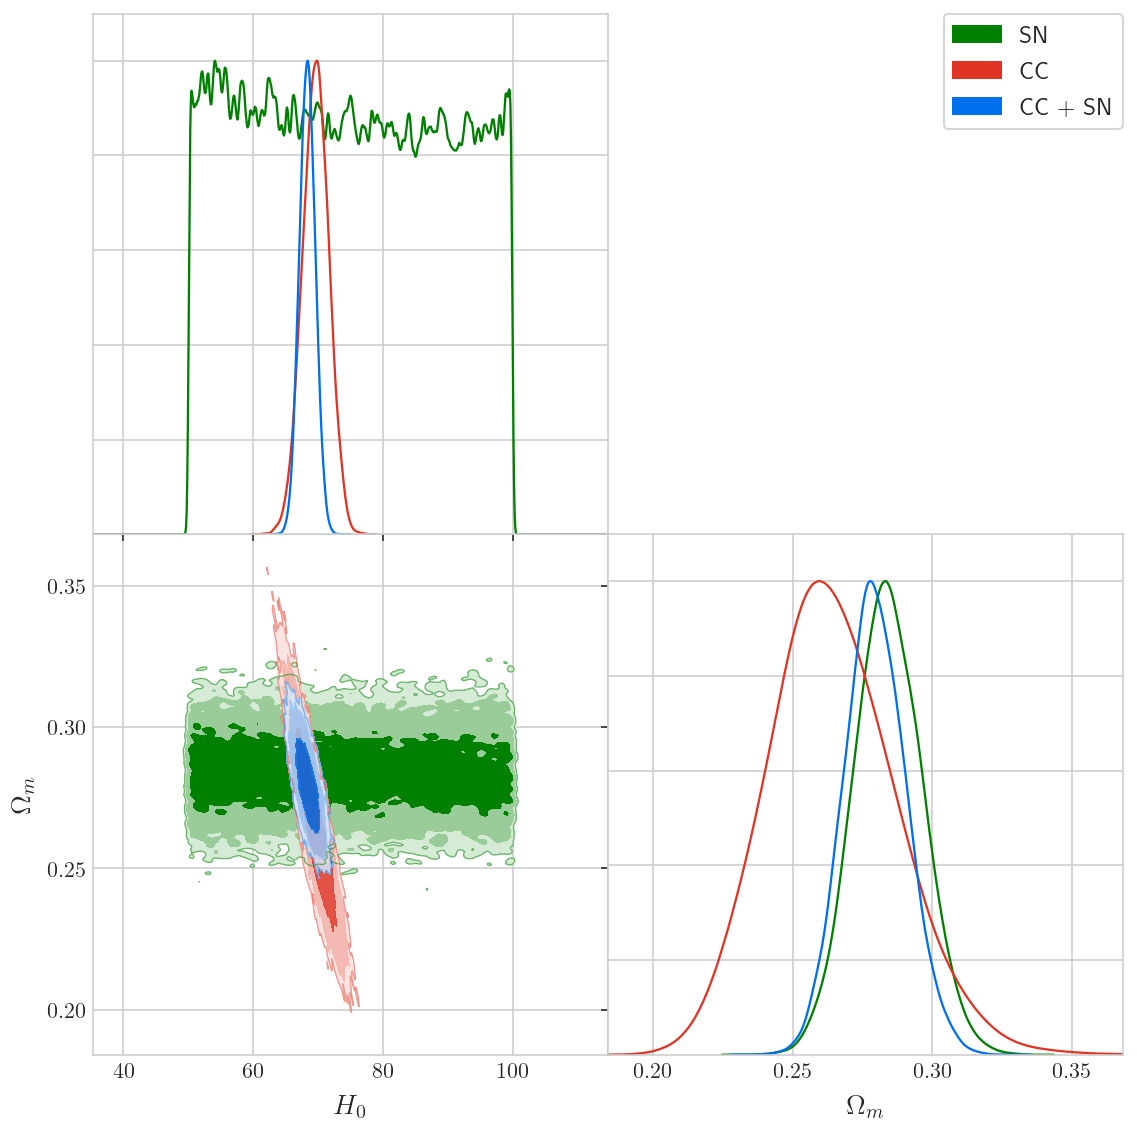

In [38]:
# Plotando os resultados
g = plots.get_subplot_plotter(4)
g.settings.num_plot_contours = 3
g.triangle_plot([samplesSN, samplesHUB, samplesTOT], legend_labels=[r'SN', r'CC', r'CC + SN'],
                colors=['green'], contour_colors = ['green'], filled=True)

In [46]:
# Resultados da estimação com 95% de confiança estatística
def constraints(samples):
    for i, mean in enumerate(samples.getMeans()):
        upper = samples.confidence(i, upper=True, limfrac=0.05)
        lower = samples.confidence(i, upper=False, limfrac=0.05)
        print("%s = %f +/- %f" % (samples.parLabel(i),\

        mean, mean - samples.confidence(i, limfrac=0.025)) )
    return

In [49]:
constraints(samplesSN)

H_0 = 74.573365 +/- 23.394228
\Omega_m = 0.284251 +/- 0.023985


In [50]:
constraints(samplesHUB)

H_0 = 69.588716 +/- 4.071529
\Omega_m = 0.264393 +/- 0.042093


In [51]:
constraints(samplesTOT)

H_0 = 68.332651 +/- 2.403389
\Omega_m = 0.279568 +/- 0.021502


## polychord

In [54]:
import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior

In [57]:
# O polychord exige esta lista vazia [] 
def loglikesn(theta):
    H0, Om = theta
    return - 0.5 * chisq_sn(theta), []

def loglikehub(theta):
    H0, Om = theta
    return -0.5 * chisq_hub(theta), []

def logliketot(theta):
    H0, Om = theta
    return -0.5*(chisq_sn(theta) + chisq_hub(theta)), []

In [56]:
# Número de pontos vivos/aceitos
nlive = 50

In [90]:
# Exibir pontos aceitos
def dumper(live, dead, logweights, logZ, logZerr):
    print("Last live point:", live)

In [91]:
# Definindo priors
def uniprior(hypercube):
    prior = []
    prior.append(UniformPrior(50.,100.)(hypercube[0]))
    prior.append(UniformPrior(0.,1.)(hypercube[1]))
    return prior

In [92]:
# Configuração e armazenamento das cadeias
settingsSN = PolyChordSettings(2,0)
settingsSN.file_root = 'logn_100'
settingsSN.nlive = nlive
settingsSN.do_clustering = True
settingsSN.read_resume = False

settingsHB = PolyChordSettings(2,0)
settingsHB.file_root = 'logb_100'
settingsHB.nlive = nlive
settingsHB.do_clustering = True
settingsHB.read_resume = False

settingsTOT = PolyChordSettings(2,0)
settingsTOT.file_root = 'logh_100'
settingsTOT.nlive = nlive
settingsTOT.do_clustering = True
settingsTOT.read_resume = False

In [93]:
outputSN = pypolychord.run_polychord(loglikesn, 2,0, settingsSN, uniprior, dumper)

Last live point: [[ 7.43488822e+01  3.57786671e-01 -1.00000000e+30 -4.00606961e+01]
 [ 6.64297327e+01  4.58194396e-01 -1.00000000e+30 -9.84459617e+01]
 [ 6.94913144e+01  4.15047135e-01 -1.00000000e+30 -6.90161609e+01]
 [ 7.12239041e+01  2.26861261e-01 -1.00000000e+30 -3.63007986e+01]
 [ 6.33373431e+01  4.51297255e-01 -1.35226140e+02 -9.33584788e+01]
 [ 8.52685846e+01  1.60876213e-01 -5.16862713e+02 -8.53446555e+01]
 [ 8.71550590e+01  3.53583683e-01 -3.45515507e+02 -3.84631947e+01]
 [ 6.88581071e+01  1.73226414e-01 -1.48265320e+02 -7.25610330e+01]
 [ 9.20928233e+01  2.85248982e-01 -3.89583027e+02 -2.48729647e+01]
 [ 8.14194713e+01  2.89291233e-01 -1.81193736e+02 -2.49525499e+01]
 [ 6.50847914e+01  2.16074566e-01 -3.85965584e+02 -4.13476860e+01]
 [ 8.70203552e+01  1.60891048e-01 -1.06396779e+02 -8.53281613e+01]
 [ 7.57790788e+01  1.53117066e-01 -2.75151070e+02 -9.43645455e+01]
 [ 7.61864521e+01  4.13982611e-01 -1.80243995e+02 -6.83660918e+01]
 [ 8.26648177e+01  4.55183439e-01 -1.00000000

Last live point: [[ 9.57120953e+01  2.81949429e-01 -2.56953138e+01 -2.48837603e+01]
 [ 6.95708155e+01  2.86477909e-01 -2.64607245e+01 -2.48864306e+01]
 [ 7.60871561e+01  2.76540188e-01 -4.55592631e+01 -2.50520044e+01]
 [ 9.74062118e+01  2.85115651e-01 -2.52697722e+01 -2.48720714e+01]
 [ 5.99893330e+01  2.90646026e-01 -2.51501148e+01 -2.50017569e+01]
 [ 7.62107212e+01  2.88688124e-01 -2.87919305e+01 -2.49342626e+01]
 [ 7.16241204e+01  2.86776597e-01 -2.50987736e+01 -2.48911255e+01]
 [ 5.70256308e+01  2.77736552e-01 -5.64390941e+01 -2.49984795e+01]
 [ 9.20928233e+01  2.85248982e-01 -3.89583027e+02 -2.48729647e+01]
 [ 8.14194713e+01  2.89291233e-01 -1.81193736e+02 -2.49525499e+01]
 [ 9.76961796e+01  2.80556624e-01 -2.54581775e+01 -2.49090604e+01]
 [ 6.23950941e+01  2.89265992e-01 -2.57197773e+01 -2.49517398e+01]
 [ 7.70702258e+01  2.90147785e-01 -2.51032614e+01 -2.49823561e+01]
 [ 5.24173601e+01  2.92569910e-01 -2.53284823e+01 -2.50908347e+01]
 [ 5.50891720e+01  2.75791224e-01 -2.52403367

Last live point: [[ 70.60241119   0.28425191 -24.88437344 -24.86898616]
 [ 72.9316158    0.28396653 -24.8704638  -24.86899781]
 [ 82.55661422   0.28411901 -24.87056691 -24.86892777]
 [ 89.44906038   0.2840965  -24.87552985 -24.86892889]
 [ 63.83391072   0.2838233  -24.86976229 -24.8691971 ]
 [ 74.65471571   0.28391606 -24.87088729 -24.86905328]
 [ 80.6471156    0.28384444 -24.87007605 -24.86915954]
 [ 92.31531218   0.2839778  -24.87125511 -24.86898762]
 [ 68.15448235   0.28442946 -24.8761907  -24.86923763]
 [ 89.33505069   0.28447557 -24.87035306 -24.86933537]
 [ 72.04847412   0.28408083 -24.86974369 -24.86893156]
 [ 73.71987169   0.28415271 -24.87024989 -24.86893205]
 [ 80.02181125   0.28423473 -24.86950025 -24.86897236]
 [ 90.4266182    0.28445334 -24.87260039 -24.86928658]
 [ 67.68658275   0.28429109 -24.87028512 -24.8690246 ]
 [ 77.5795407    0.2839706  -24.88144702 -24.86899404]
 [ 72.32966526   0.28434956 -24.87839708 -24.86909991]
 [ 65.72890113   0.28414894 -25.37299358 -24.868

Last live point: [[ 95.2177709    0.28411144 -24.86893511 -24.86892779]
 [ 96.04760089   0.28411272 -24.86893047 -24.86892776]
 [ 95.61037897   0.28411967 -24.86892978 -24.86892779]
 [ 94.11774029   0.28411203 -24.86892826 -24.86892777]
 [ 94.41240653   0.2841208  -24.86892889 -24.86892782]
 [ 94.82697457   0.28411085 -24.86892795 -24.86892781]
 [ 55.13916763   0.28411547 -24.86892965 -24.86892773]
 [ 53.86404711   0.28411387 -24.86892842 -24.86892775]
 [ 53.7595185    0.28411579 -24.86892807 -24.86892773]
 [ 52.67616133   0.28411001 -24.86894058 -24.86892783]
 [ 52.57537029   0.28411448 -24.86894546 -24.86892774]
 [ 50.65024436   0.28412058 -24.86892817 -24.86892781]
 [ 53.17255173   0.28412007 -24.86892885 -24.8689278 ]
 [ 51.69694939   0.28411587 -24.86893032 -24.86892773]
 [ 53.11654101   0.28412094 -24.86892958 -24.86892782]
 [ 54.53884524   0.2841154  -24.86892922 -24.86892773]
 [ 53.00898797   0.28411583 -24.86892819 -24.86892773]
 [ 57.78409415   0.28412194 -24.86892866 -24.868

In [94]:
outputHUB = pypolychord.run_polychord(loglikehub, 2,0, settingsHB, uniprior, dumper)

Last live point: [[ 6.79214914e+01  1.33529996e-01 -5.17761094e+02 -1.35950621e+02]
 [ 8.77846703e+01  1.83404754e-01 -2.05529811e+03 -7.69490895e+01]
 [ 6.79458139e+01  2.78418688e-01 -3.43773491e+03 -9.59140923e+00]
 [ 5.94753471e+01  2.59483598e-01 -1.00000000e+30 -7.58114593e+01]
 [ 9.12025244e+01  2.06474454e-01 -1.00000000e+30 -1.60411514e+02]
 [ 6.12620143e+01  3.94230166e-01 -1.00000000e+30 -1.95013508e+01]
 [ 8.88308451e+01  1.70510911e-01 -1.33530582e+03 -7.52672884e+01]
 [ 7.25280637e+01  3.79625849e-01 -3.21863782e+02 -1.09465948e+02]
 [ 6.61193666e+01  3.46864637e-01 -3.30403727e+02 -1.86046341e+01]
 [ 7.33821799e+01  1.30879915e-01 -2.96128333e+02 -8.32703182e+01]
 [ 5.63566954e+01  7.53909680e-01 -4.07480216e+02 -1.74068522e+02]
 [ 5.36355320e+01  3.80421840e-01 -8.06446189e+02 -6.82335208e+01]
 [ 6.48758086e+01  3.12185874e-01 -2.90293132e+02 -1.19934148e+01]
 [ 5.22205384e+01  3.32054728e-01 -6.36782995e+02 -1.22685483e+02]
 [ 5.68117357e+01  4.75655140e-01 -1.00000000

Last live point: [[ 7.12521747e+01  2.53302939e-01 -1.61361765e+01 -9.69285997e+00]
 [ 6.46174779e+01  3.37412881e-01 -2.46274531e+01 -1.33626962e+01]
 [ 6.79458139e+01  2.78418688e-01 -3.43773491e+03 -9.59140923e+00]
 [ 6.90782118e+01  2.60410485e-01 -1.76816533e+01 -9.55250680e+00]
 [ 6.36700470e+01  3.36386966e-01 -2.91362650e+01 -1.34976555e+01]
 [ 6.98964409e+01  2.67853085e-01 -1.95714910e+01 -9.50798255e+00]
 [ 6.99021355e+01  2.59065274e-01 -4.00858851e+01 -9.20890496e+00]
 [ 6.60578352e+01  3.22679341e-01 -1.76117896e+01 -1.24704600e+01]
 [ 7.51625026e+01  2.18884295e-01 -1.87972399e+01 -1.30191235e+01]
 [ 6.50131045e+01  3.35126303e-01 -1.46641243e+01 -1.33224458e+01]
 [ 7.20256355e+01  2.41534270e-01 -3.90796247e+01 -9.85499715e+00]
 [ 7.43743796e+01  2.37890956e-01 -1.52965246e+01 -1.38791081e+01]
 [ 6.48758086e+01  3.12185874e-01 -2.90293132e+02 -1.19934148e+01]
 [ 7.04711739e+01  2.24432135e-01 -1.78029085e+01 -1.42173825e+01]
 [ 6.96191649e+01  2.81230448e-01 -3.00593942

Last live point: [[ 69.61623669   0.26274016  -9.43912649  -9.20239756]
 [ 69.45459796   0.26718366  -9.55507367  -9.2460269 ]
 [ 69.41936021   0.26788749  -9.51378305  -9.25819728]
 [ 69.9021355    0.25906527 -40.0858851   -9.20890496]
 [ 69.18965126   0.26822749  -9.52214658  -9.24090206]
 [ 69.94831855   0.25610992  -9.87364235  -9.2664356 ]
 [ 70.14625074   0.25460419 -16.97815586  -9.26795359]
 [ 69.46488185   0.2585734   -9.77262261  -9.37475541]
 [ 69.75017611   0.26592862 -10.19400671  -9.29845571]
 [ 70.52470957   0.25391763  -9.67775884  -9.27747319]
 [ 69.11158931   0.27045461  -9.3810166   -9.27606558]
 [ 69.628244     0.26213788 -10.38115724  -9.20370015]
 [ 69.50644666   0.26146352  -9.77733542  -9.2369137 ]
 [ 69.56708126   0.2673863   -9.38019421  -9.28487583]
 [ 69.63382654   0.25911527 -11.151134    -9.26455403]
 [ 69.6543676    0.26441414 -10.44659246  -9.2205863 ]
 [ 69.89484317   0.26333018  -9.61636582  -9.25787097]
 [ 68.85989962   0.27261528  -9.40907591  -9.310

Last live point: [[ 69.61623669   0.26274016  -9.43912649  -9.20239756]
 [ 69.9021355    0.25906527 -40.0858851   -9.20890496]
 [ 69.96650989   0.25857319  -9.25068058  -9.21088945]
 [ 69.69559563   0.26149708  -9.26815823  -9.202484  ]
 [ 69.75470327   0.26292431  -9.23409467  -9.21180741]
 [ 69.67832195   0.26166932  -9.21398026  -9.20264743]
 [ 69.628244     0.26213788 -10.38115724  -9.20370015]
 [ 69.66815053   0.26340619  -9.21246522  -9.20722122]
 [ 69.73224161   0.26153036  -9.21938249  -9.20100438]
 [ 69.91903338   0.25950161  -9.221896    -9.20585204]
 [ 69.71108807   0.26082477  -9.21337723  -9.20655057]
 [ 69.60527116   0.26331779  -9.24378599  -9.2033509 ]
 [ 69.87594263   0.26124832  -9.21453533  -9.20858872]
 [ 69.79861962   0.26091363  -9.21576338  -9.20156753]
 [ 69.70618556   0.26141906  -9.46346454  -9.20227365]
 [ 69.64476894   0.2619397   -9.23618198  -9.20353896]
 [ 69.70661825   0.26248261  -9.21342904  -9.2024613 ]
 [ 69.76177421   0.26271309  -9.21898287  -9.209

In [95]:
outputTOT = pypolychord.run_polychord(logliketot, 2,0, settingsTOT, uniprior, dumper)

Last live point: [[ 6.31410076e+01  1.31228410e-01 -9.12845148e+02 -3.36725263e+02]
 [ 7.71050421e+01  2.43798312e-01 -1.00000000e+30 -6.03239897e+01]
 [ 6.50719113e+01  3.23847093e-01 -1.00000000e+30 -4.16232331e+01]
 [ 5.15064131e+01  6.19068651e-01 -3.65150674e+02 -2.97098597e+02]
 [ 7.81213270e+01  3.21202039e-01 -1.32309268e+03 -1.55230839e+02]
 [ 7.68981750e+01  1.24680339e-01 -8.72897447e+02 -2.03050124e+02]
 [ 8.03752712e+01  2.81841952e-01 -9.01070427e+02 -1.30633501e+02]
 [ 5.49685066e+01  2.20654497e-01 -7.31501780e+02 -2.36875691e+02]
 [ 7.77839222e+01  4.03622325e-01 -1.30039410e+03 -3.30693169e+02]
 [ 6.50182008e+01  4.02259509e-01 -1.00000000e+30 -9.88987986e+01]
 [ 6.40655136e+01  3.71971855e-01 -4.44292685e+02 -6.56815589e+01]
 [ 7.78545527e+01  3.82026559e-01 -6.03866884e+02 -2.77432338e+02]
 [ 6.03343337e+01  2.67197531e-01 -1.00000000e+30 -8.49642272e+01]
 [ 5.50191326e+01  5.50138105e-01 -5.36960097e+02 -2.19106883e+02]
 [ 5.82198062e+01  4.80802118e-01 -1.00000000

Last live point: [[ 6.73422969e+01  2.75103171e-01 -5.70667809e+01 -3.56080915e+01]
 [ 6.78287113e+01  3.18232359e-01 -4.71353813e+01 -4.36337418e+01]
 [ 6.50719113e+01  3.23847093e-01 -1.00000000e+30 -4.16232331e+01]
 [ 7.17777122e+01  2.67291371e-01 -1.58583253e+02 -3.88997878e+01]
 [ 6.50578886e+01  3.23755064e-01 -6.03239897e+01 -4.15975663e+01]
 [ 7.30456873e+01  2.38965606e-01 -5.71798313e+01 -4.27368827e+01]
 [ 7.15645366e+01  2.64799005e-01 -5.58892392e+01 -3.79856820e+01]
 [ 6.42515147e+01  2.83345668e-01 -4.50422138e+01 -4.37426076e+01]
 [ 6.54928330e+01  3.07684054e-01 -8.18914421e+01 -3.78451897e+01]
 [ 6.31446420e+01  3.17568842e-01 -4.50316877e+01 -4.39261867e+01]
 [ 6.54637497e+01  2.77369175e-01 -4.57577978e+01 -4.02859078e+01]
 [ 6.39025835e+01  3.01649481e-01 -8.48653166e+01 -4.15465958e+01]
 [ 6.96818206e+01  2.76938333e-01 -5.84173681e+01 -3.52941528e+01]
 [ 6.62512389e+01  3.15501202e-01 -4.52275875e+01 -3.94463331e+01]
 [ 7.28157031e+01  2.67801760e-01 -4.83174914

Last live point: [[ 69.36168295   0.27488146 -35.39666966 -34.79098985]
 [ 68.34065596   0.27275275 -36.71959996 -34.76108041]
 [ 67.23971989   0.2852736  -35.20573285 -34.83607388]
 [ 69.5208563    0.27303219 -35.26032075 -34.88400156]
 [ 68.23433892   0.28316915 -35.44419157 -34.50078574]
 [ 67.88605326   0.2901696  -35.18683459 -34.96266237]
 [ 67.72462236   0.27751388 -38.04411016 -34.80011416]
 [ 68.14175053   0.28045915 -35.93246098 -34.43442842]
 [ 68.62926287   0.28415778 -35.19780747 -34.78858738]
 [ 67.8720291    0.2818503  -35.1252893  -34.49603818]
 [ 67.49780253   0.2869208  -35.45562409 -34.69459943]
 [ 68.92375552   0.28203275 -35.30229393 -34.84845989]
 [ 67.99593559   0.27776824 -35.1509139  -34.56972954]
 [ 69.03438417   0.2709885  -35.65880685 -34.7060173 ]
 [ 68.32779525   0.28288483 -40.65601215 -34.51287273]
 [ 68.26866335   0.28276692 -47.08454233 -34.49018131]
 [ 68.16274583   0.27266654 -36.97379376 -34.90607376]
 [ 67.66320787   0.28854932 -35.23853342 -34.753

Last live point: [[ 68.584444     0.27775603 -34.49161261 -34.44034056]
 [ 68.20139774   0.28043706 -34.63758353 -34.42784632]
 [ 68.23915938   0.28031729 -34.58789506 -34.42529259]
 [ 68.21866513   0.27992863 -34.45699158 -34.4262913 ]
 [ 68.26171635   0.27861215 -34.50463852 -34.43490454]
 [ 68.20079216   0.28146835 -34.61317965 -34.43927525]
 [ 68.14175053   0.28045915 -35.93246098 -34.43442842]
 [ 68.62090093   0.27807776 -34.48142699 -34.44851309]
 [ 68.08741419   0.2801039  -34.49661732 -34.44799849]
 [ 68.11213687   0.28029268 -34.4679992  -34.44043197]
 [ 68.13877379   0.28147288 -34.4682852  -34.44013194]
 [ 68.33898651   0.27773968 -34.45807371 -34.44129768]
 [ 68.60123361   0.27798725 -34.49603818 -34.4437206 ]
 [ 68.35572988   0.28092958 -34.4915088  -34.44274018]
 [ 68.4155065    0.27880981 -34.46843813 -34.4227757 ]
 [ 68.25310811   0.2786751  -34.56786051 -34.43522304]
 [ 68.40189084   0.27736924 -34.46212749 -34.44183948]
 [ 68.36924134   0.28010403 -34.47129127 -34.427

Last live point: [[ 68.27449365   0.27987698 -34.4437206  -34.42257079]
 [ 68.29999801   0.27993003 -34.42378423 -34.42236561]
 [ 68.28687589   0.27976628 -34.42583948 -34.42202088]
 [ 68.2942415    0.27959327 -34.54838767 -34.42174114]
 [ 68.33630132   0.27941904 -34.43366292 -34.42099094]
 [ 68.32358203   0.27960867 -34.42278397 -34.42125879]
 [ 68.33687111   0.27924627 -34.42283588 -34.42109646]
 [ 68.33295625   0.27918043 -34.42332059 -34.4213549 ]
 [ 68.39334812   0.27922406 -34.42547774 -34.42217112]
 [ 68.36884104   0.27909118 -34.42281623 -34.42124868]
 [ 68.36153498   0.27966271 -34.42278037 -34.42263431]
 [ 68.37657949   0.27936372 -34.42477852 -34.42181434]
 [ 68.3532464    0.27947668 -34.42274669 -34.42134186]
 [ 68.34393661   0.27970766 -34.42834511 -34.4220854 ]
 [ 68.37806433   0.27878387 -34.42599328 -34.42222338]
 [ 68.34153532   0.27901164 -34.43552416 -34.42181243]
 [ 68.33010197   0.27907068 -34.43549878 -34.42192922]
 [ 68.35618099   0.27967134 -34.42305092 -34.422

In [96]:
paramnames = [('h0','H_0 (km s^{-1} Mpc^{-1})'),('om', '\Omega_m')]
outputSN.make_paramnames_files(paramnames)
posteriorSN = outputSN.posterior

paramnames = [('h0','H_0 (km s^{-1} Mpc^{-1})'),('om', '\Omega_m')]
outputHUB.make_paramnames_files(paramnames)
posteriorHUB = outputHUB.posterior

paramnames = [('h0','H_0 (km s^{-1} Mpc^{-1})'),('om', '\Omega_m')]
outputTOT.make_paramnames_files(paramnames)
posteriorTOT = outputTOT.posterior

chains/logn_100.txt
Removed no burn in
chains/logb_100.txt
Removed no burn in
chains/logh_100.txt
Removed no burn in


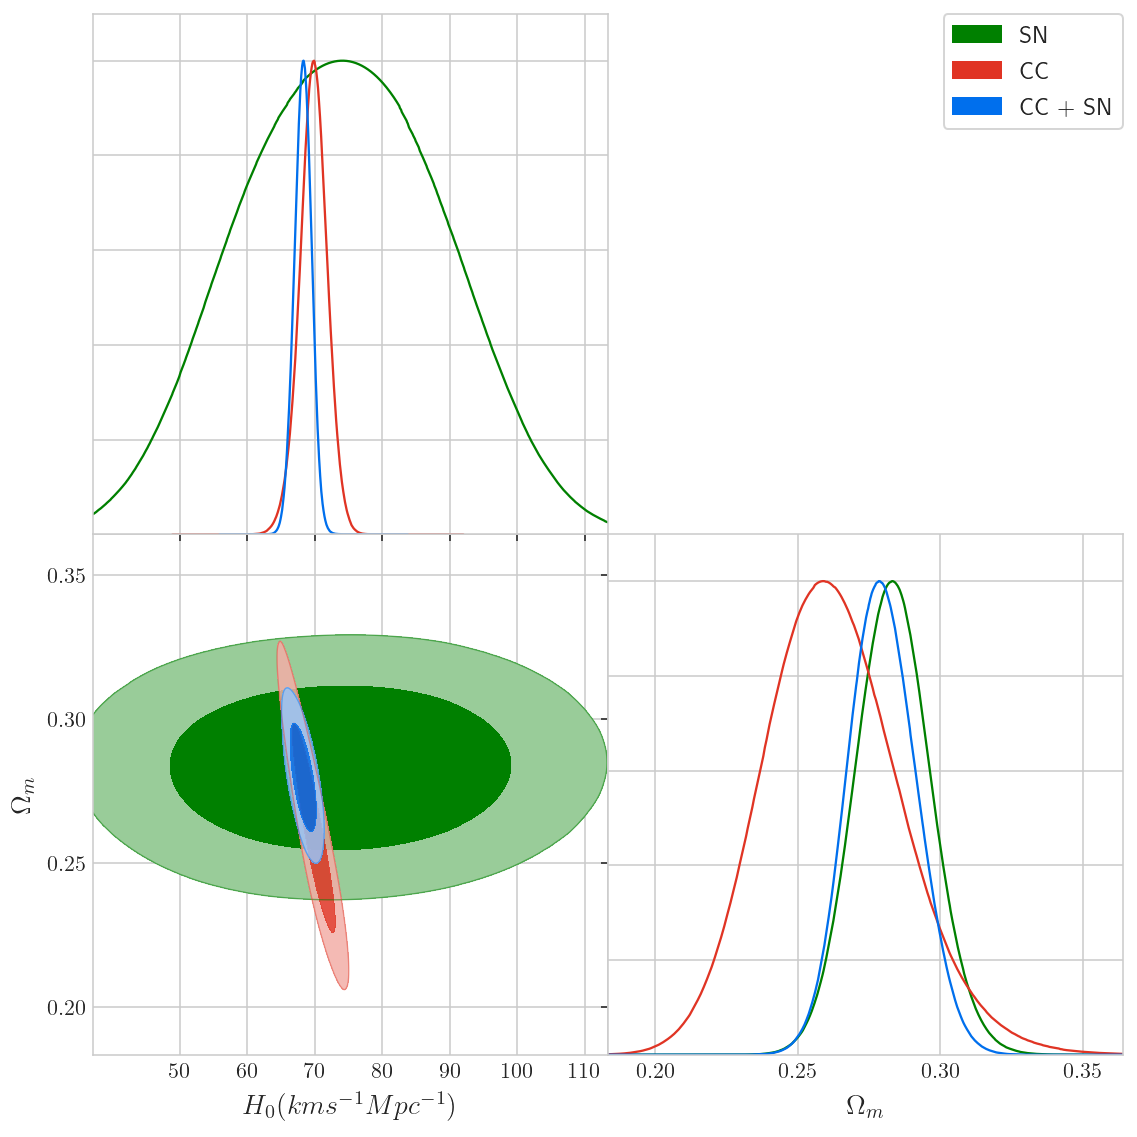

In [97]:
g = getdist.plots.getSubplotPlotter(4)
#g.settings.line_styles = 'Dark2'
#g.settings.solid_colors='Dark2'
g.triangle_plot([posteriorSN,posteriorHUB,posteriorTOT], ('h0','om') , filled=True,
                legend_labels=[r'SN', r'CC', r'CC + SN'], colors=['green'], 
                contour_colors = ['green'])

In [98]:
constraints(posteriorSN)

H_0 (km s^{-1} Mpc^{-1}) = 73.947100 +/- 22.538495
\Omega_m = 0.283426 +/- 0.023770


In [99]:
constraints(posteriorHUB)

H_0 (km s^{-1} Mpc^{-1}) = 69.794290 +/- 4.294923
\Omega_m = 0.261809 +/- 0.038956


In [100]:
constraints(posteriorTOT)

H_0 (km s^{-1} Mpc^{-1}) = 68.251247 +/- 2.231704
\Omega_m = 0.279685 +/- 0.020850
